# LLM 实现
LLM（如GPT，即生成式预训练 Transformer，Generative Pretrained Transformer）是一种大型深度神经网络架构，设计用于逐词（或逐 token）生成新文本。
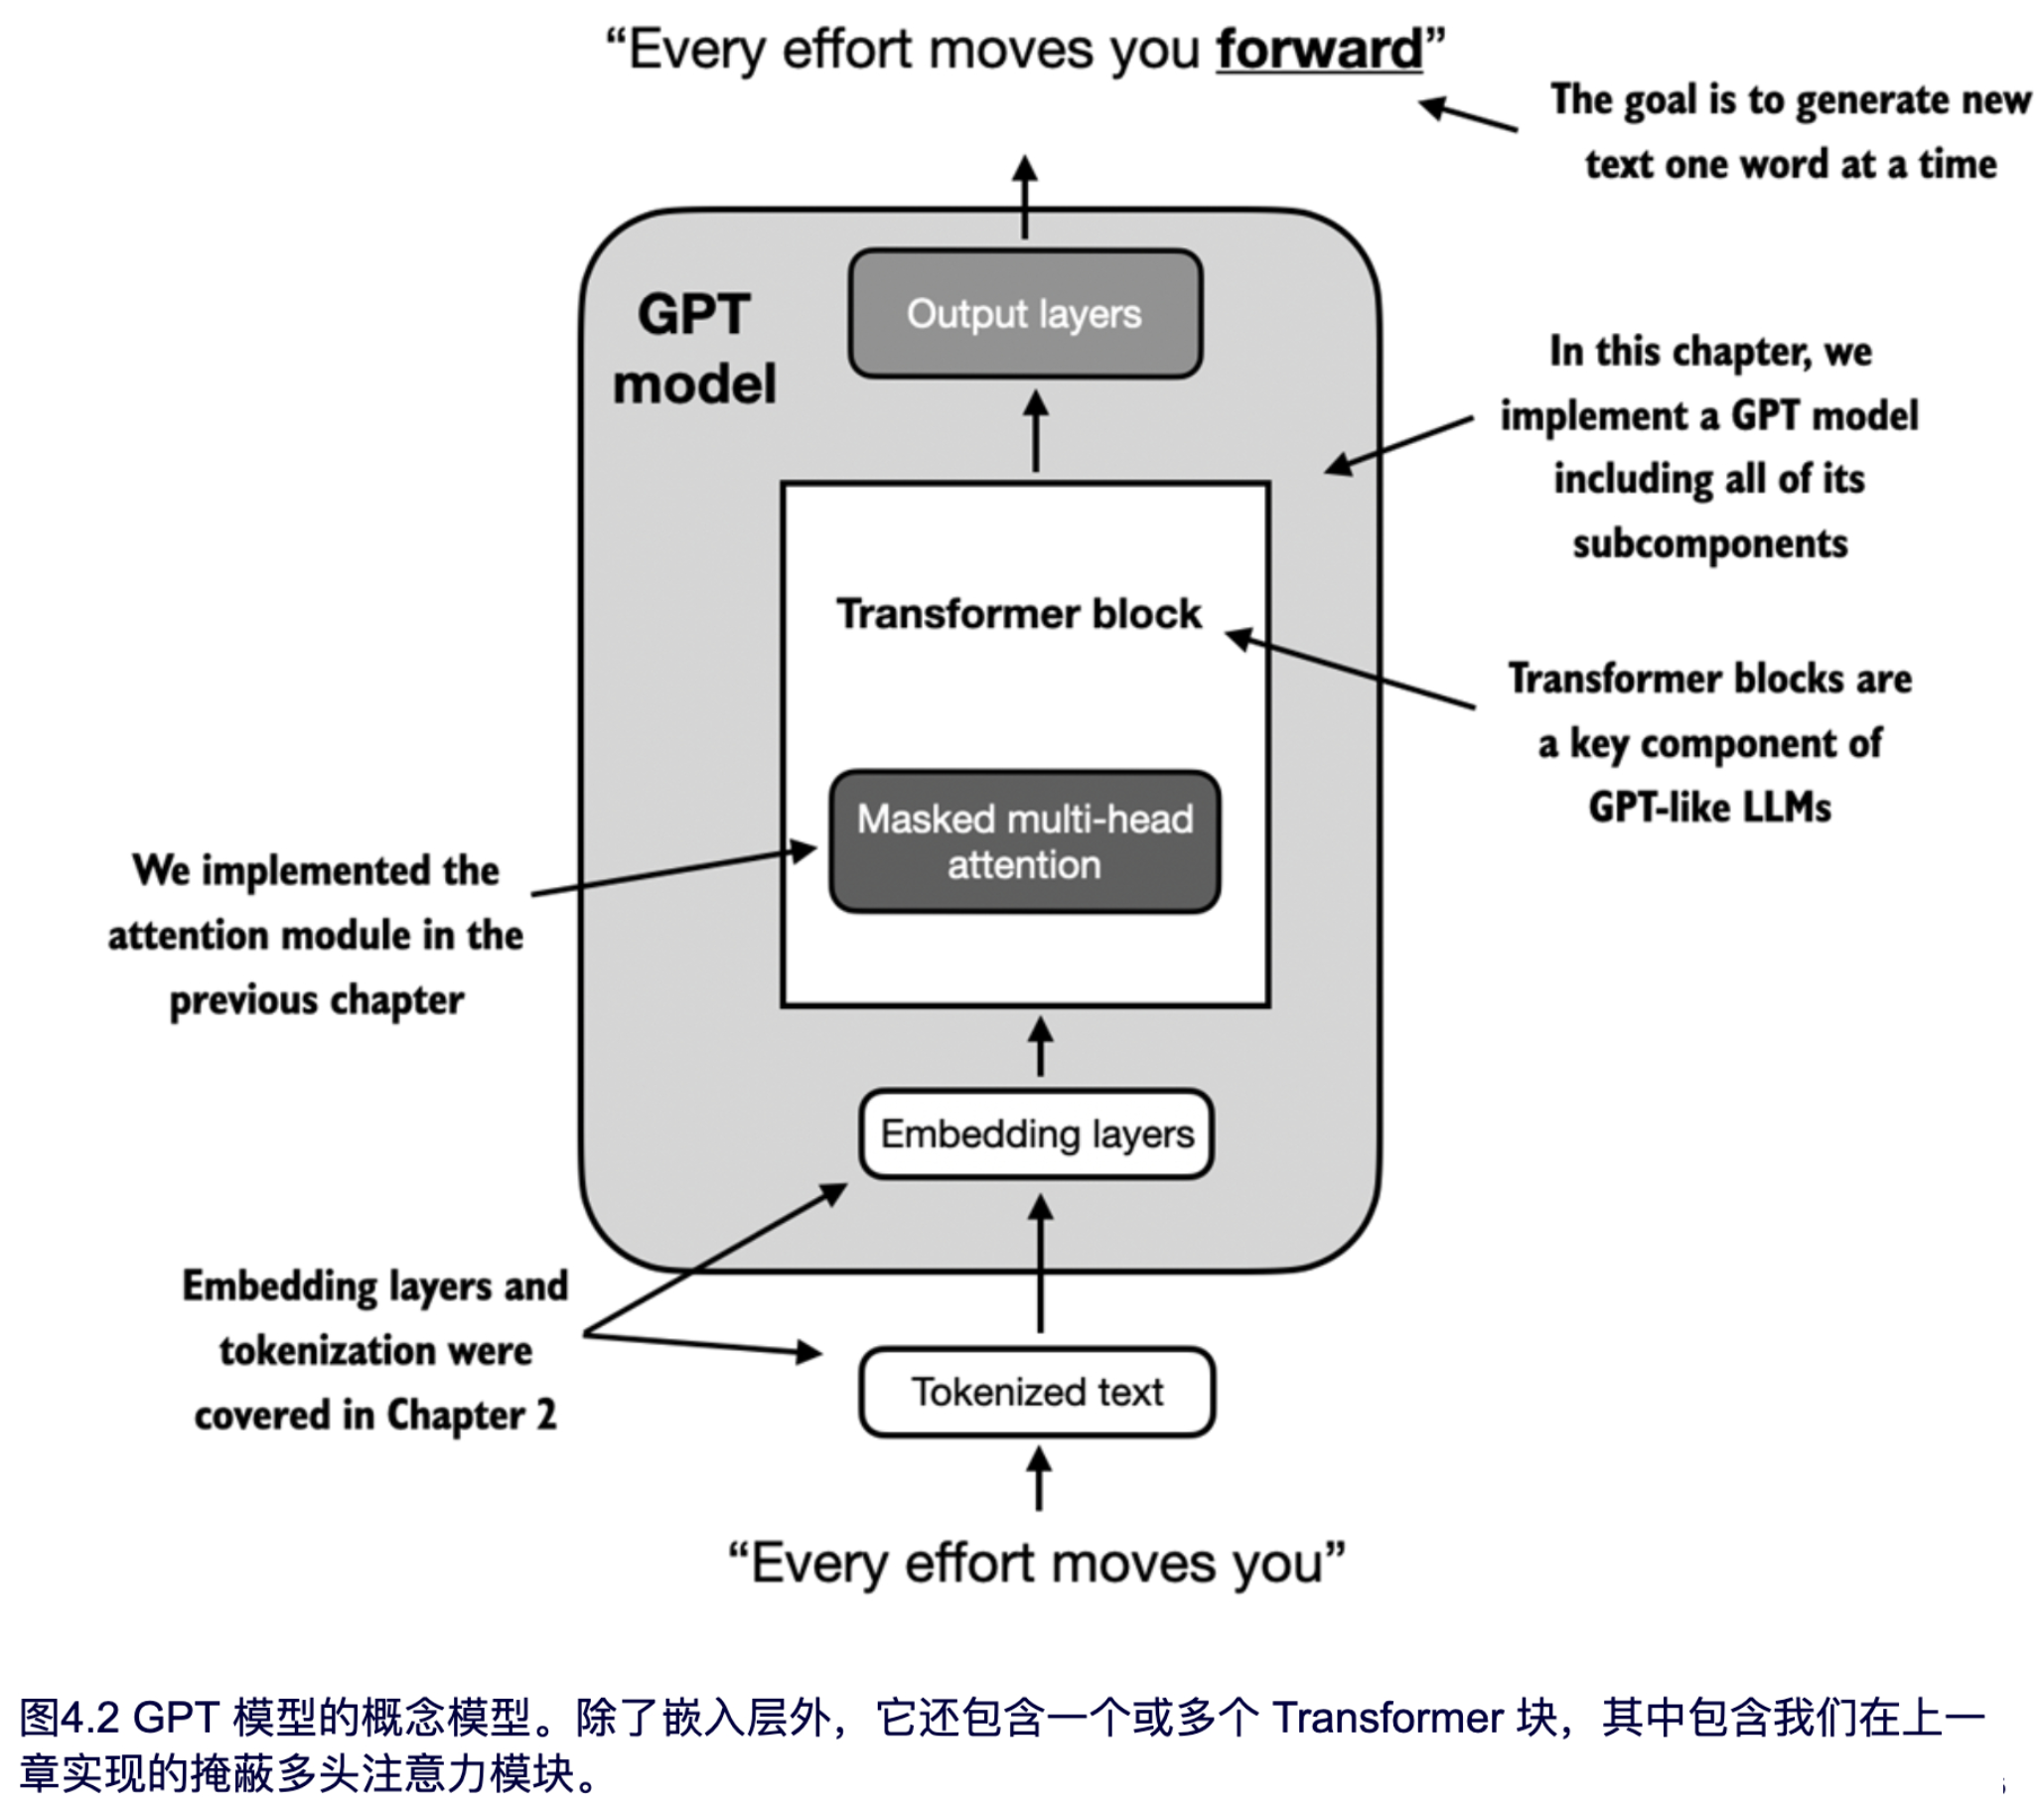

In [1]:
#定义小型 GPT-2 模型的配置
GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 1024,
    'emb_dim': 768,
    'n_heads':12,
    'n_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False
}

## LLM架构概览
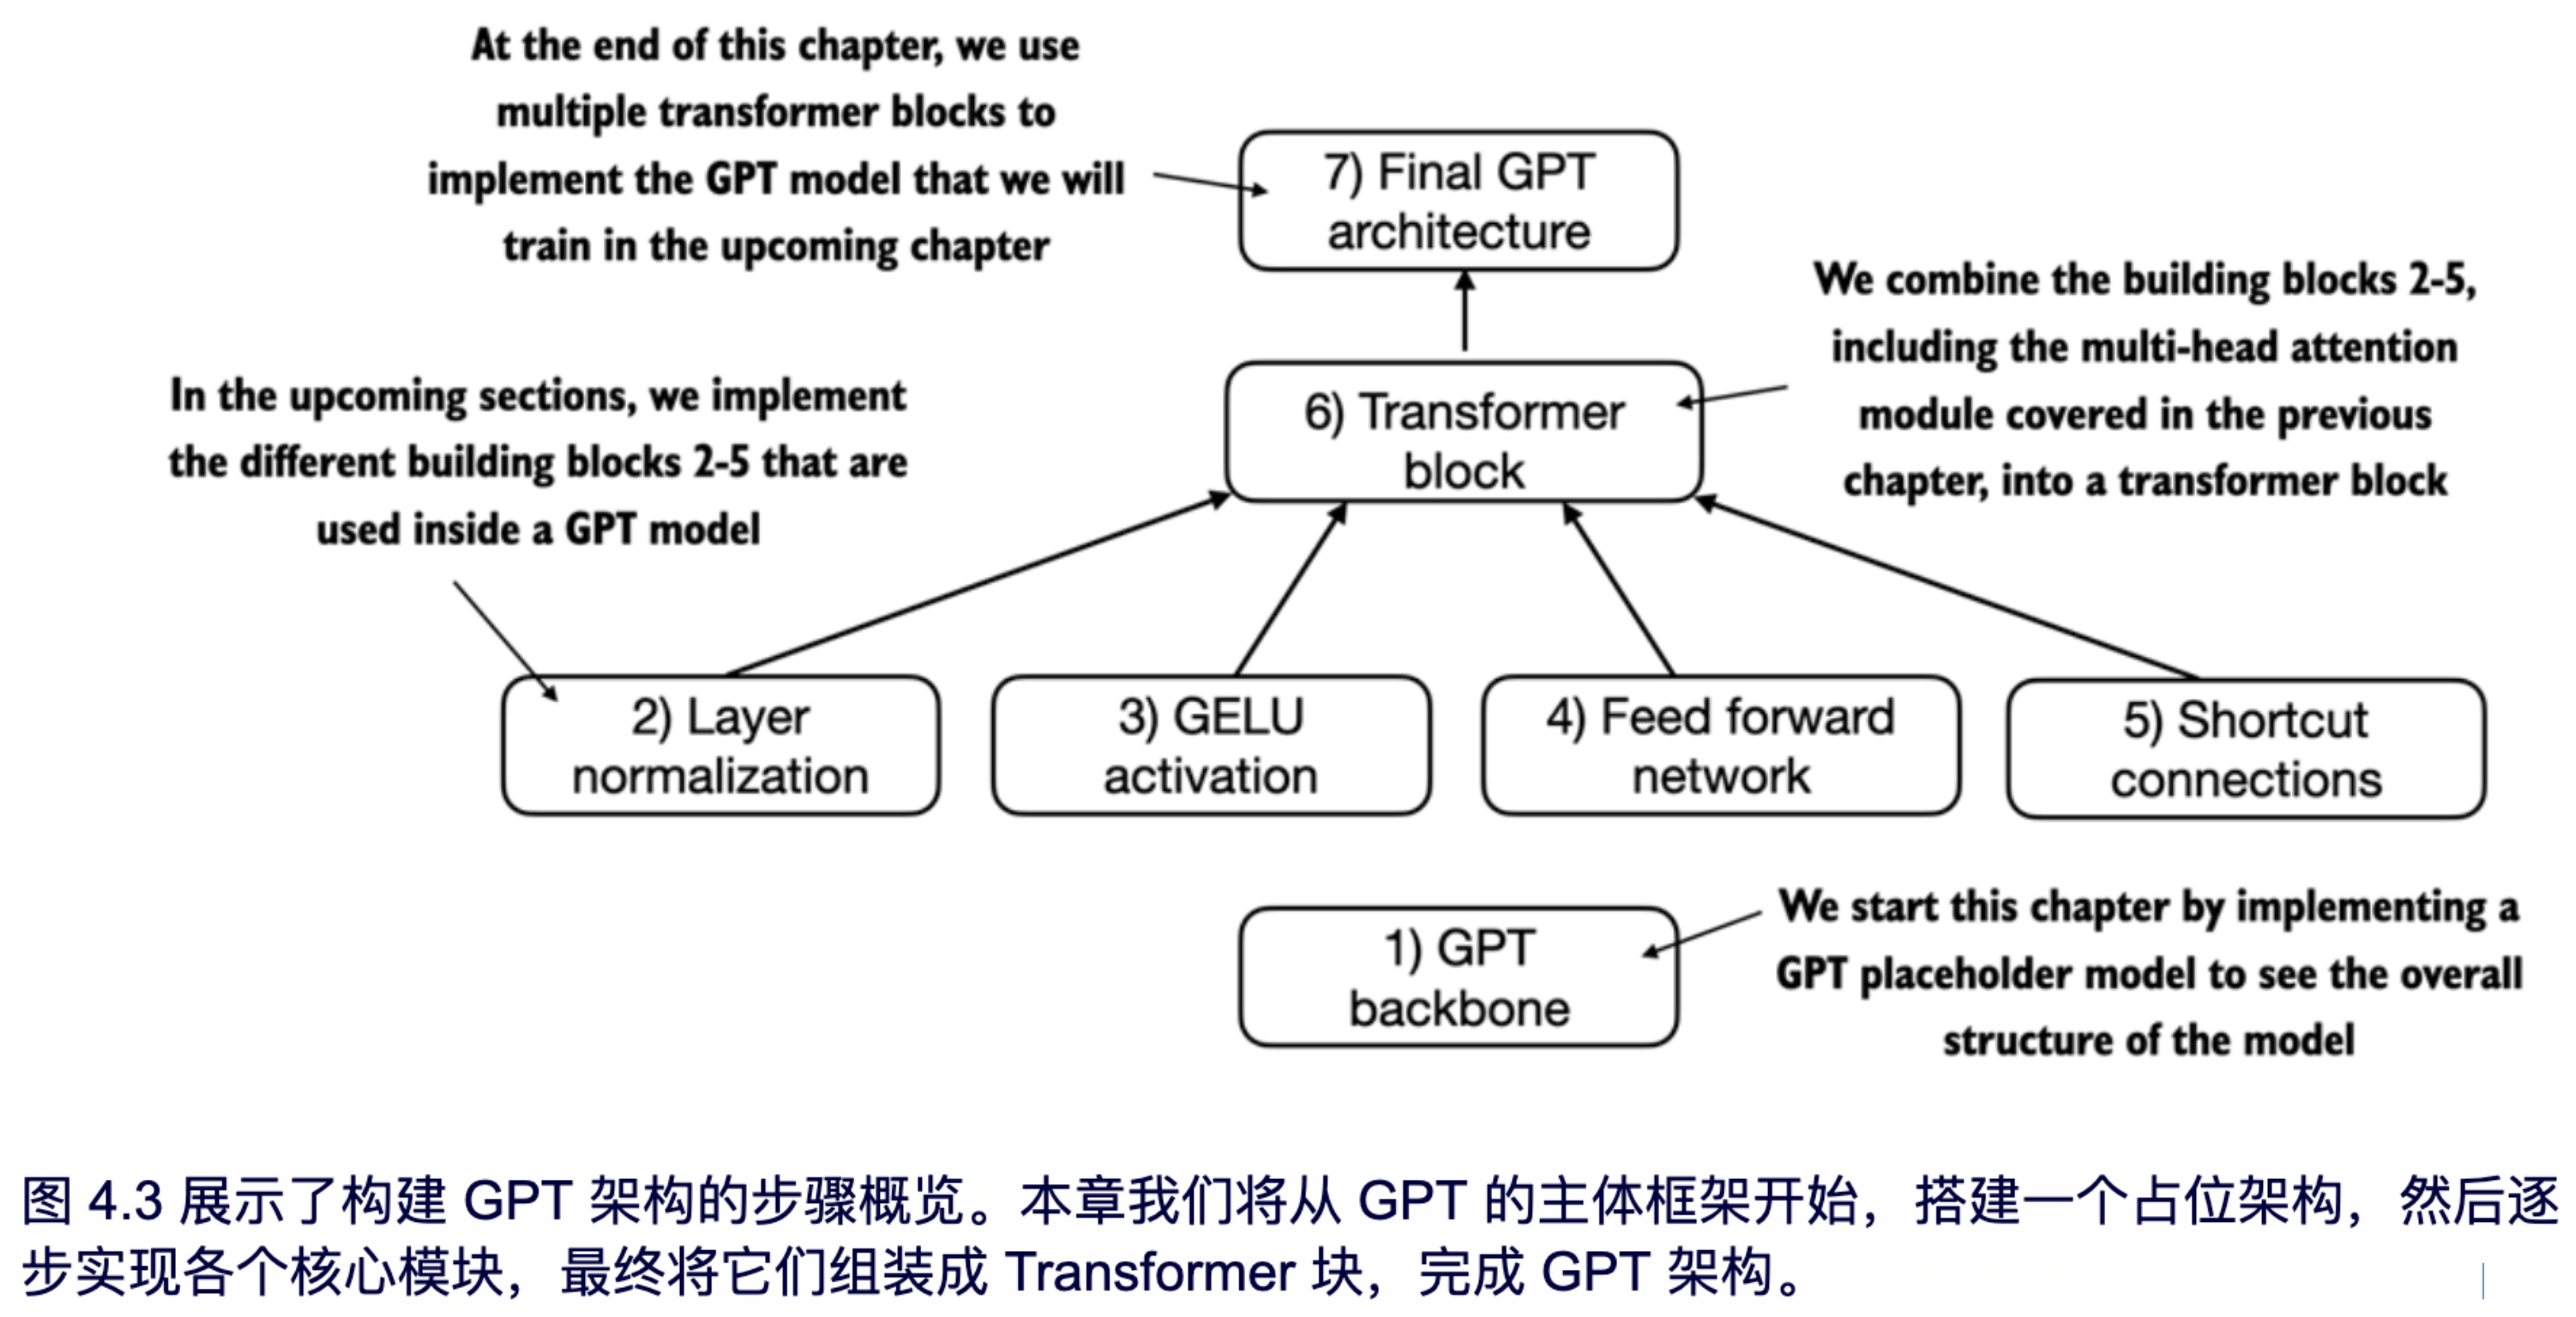

In [6]:
import torch
import torch.nn as nn
# 分为三大层  
# A 编码层 -> 词嵌入 位置嵌入 
# B transformer blocks
# C 输出层 归一化+输出
class DummyGPTmodel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'],bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        token_embed = self.tok_emb(in_idx)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = token_embed + pos_emb
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    



class DummyTransformerBlock(nn.Module):                                       #C
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):                                                     #D
        return x

class DummyLayerNorm(nn.Module):                                              #E
    def __init__(self, normalized_shape, eps=1e-5):                           #F
        super().__init__()

    def forward(self, x):
        return x

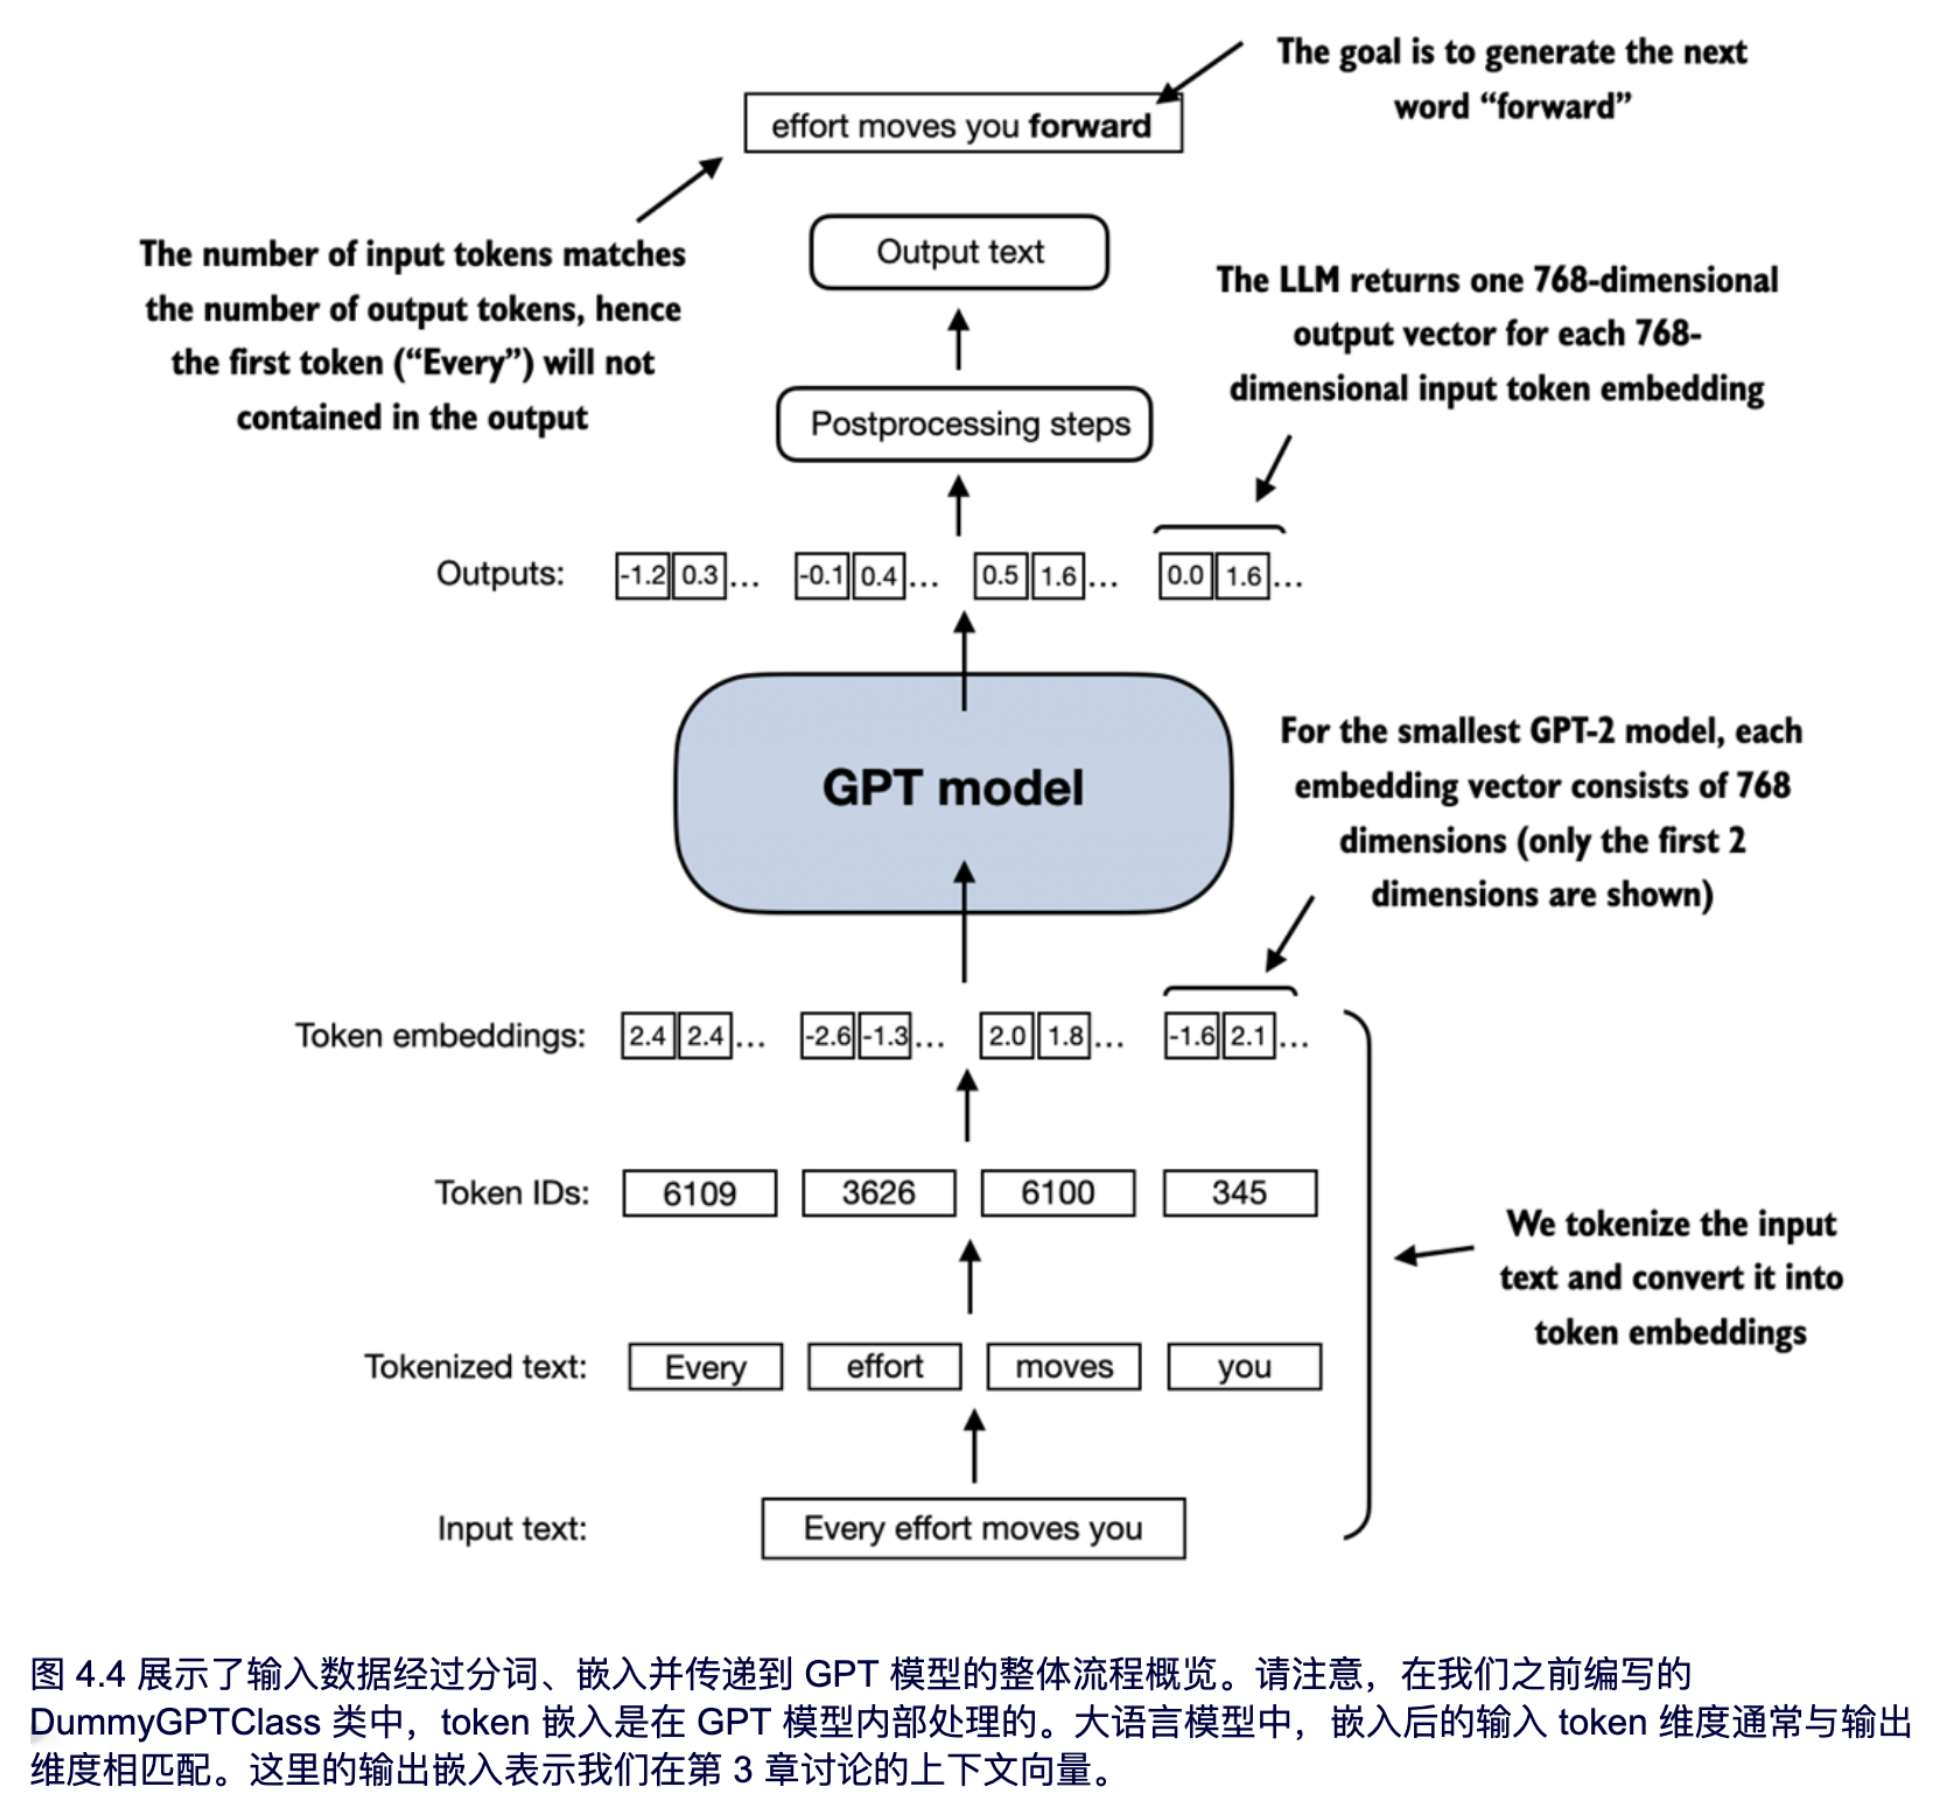

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
#测试模型输出
torch.manual_seed(123)
model = DummyGPTmodel(cfg=GPT_CONFIG_124M)
logits = model(batch)
print(logits.shape)

torch.Size([2, 4, 50257])


## 搭建Transformer Block  
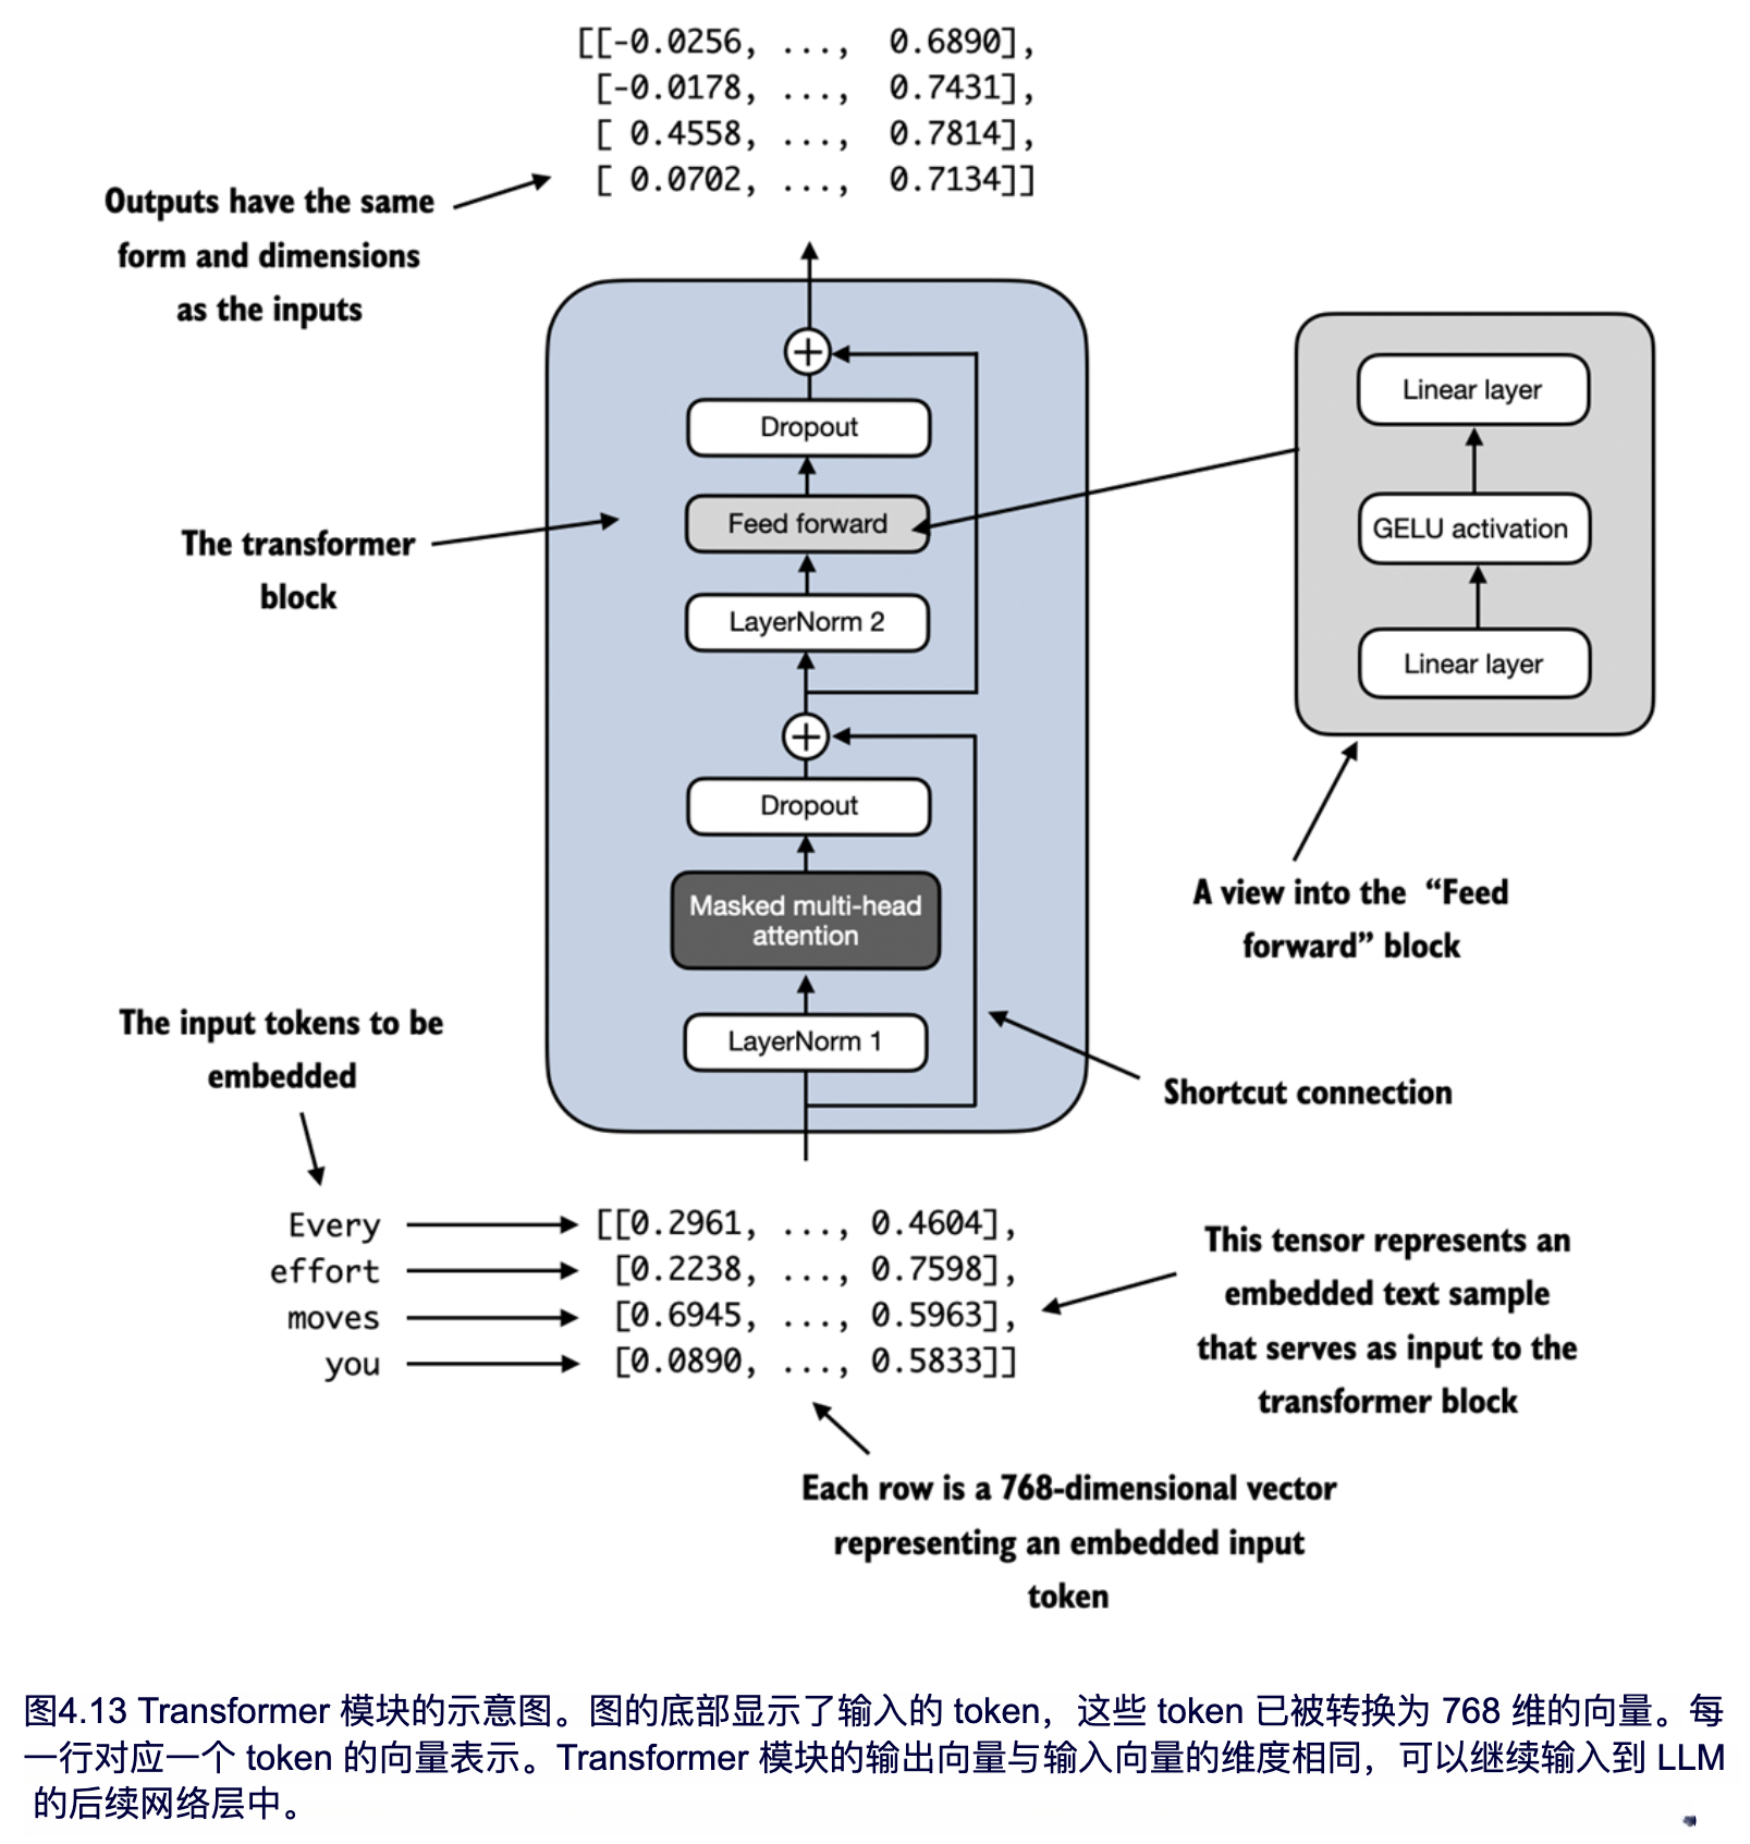

In [8]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']),
            nn.GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )
    def forward(self, x):
        return self.layers(x)

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,num_heads,dropout,qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_in = d_in
        self.d_out = d_out
        self.context_length = context_length
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # 必须是整除
        self.dropout = nn.Dropout(dropout)
        self.W_q = nn.Linear(in_features=d_in, out_features=d_out,bias=qkv_bias)
        self.W_k = nn.Linear(in_features=d_in, out_features=d_out,bias=qkv_bias)
        self.W_v = nn.Linear(in_features=d_in, out_features=d_out,bias=qkv_bias)
        self.out_proj = nn.Linear(in_features=d_out, out_features=d_out)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length),diagonal=1)
        )
        
    def forward(self, x):
        b, num_tokens, d_in =x.shape
        queries = self.W_q(x).view(b, num_tokens, self.num_heads, self.head_dim)
        keys = self.W_k(x).view(b, num_tokens, self.num_heads, self.head_dim)
        values = self.W_v(x).view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.transpose(1,2) # [b, num_heads, num_tokens, head_dim]
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        atten_scroe = queries @ keys.transpose(2,3) / keys.shape[-1] ** 0.5
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        atten_scroe.masked_fill_(mask_bool, -torch.inf)
        atten_weight = torch.softmax(atten_scroe, dim=-1)
        atten_weight = self.dropout(atten_weight)
        content_vec = atten_weight @ values# [b, num_heads, num_tokens, head_dim]
        content_vec = content_vec.transpose(1,2).contiguous().view(b, num_tokens, self.d_out)# [b, num_tokens, d_out]
        content_vec = self.out_proj(content_vec)
        return content_vec

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(cfg['emb_dim'],
                                      cfg['emb_dim'],
                                      cfg['context_length'],
                                      cfg['n_heads'],
                                      cfg['drop_rate'],
                                      qkv_bias=cfg['qkv_bias'])
        self.ff = FeedForward(cfg)
        self.LN1 = nn.LayerNorm(cfg['emb_dim'])
        self.LN2 = nn.LayerNorm(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self,x):
        shoutcut = x # 后面用于残差连接
        x = self.LN1(x)
        x = self.att(x)
        x = self.dropout(x)
        x = x + shoutcut
        shoutcut = x
        x = self.LN2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shoutcut
        return x

In [14]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)                    #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 实现GPT模型  
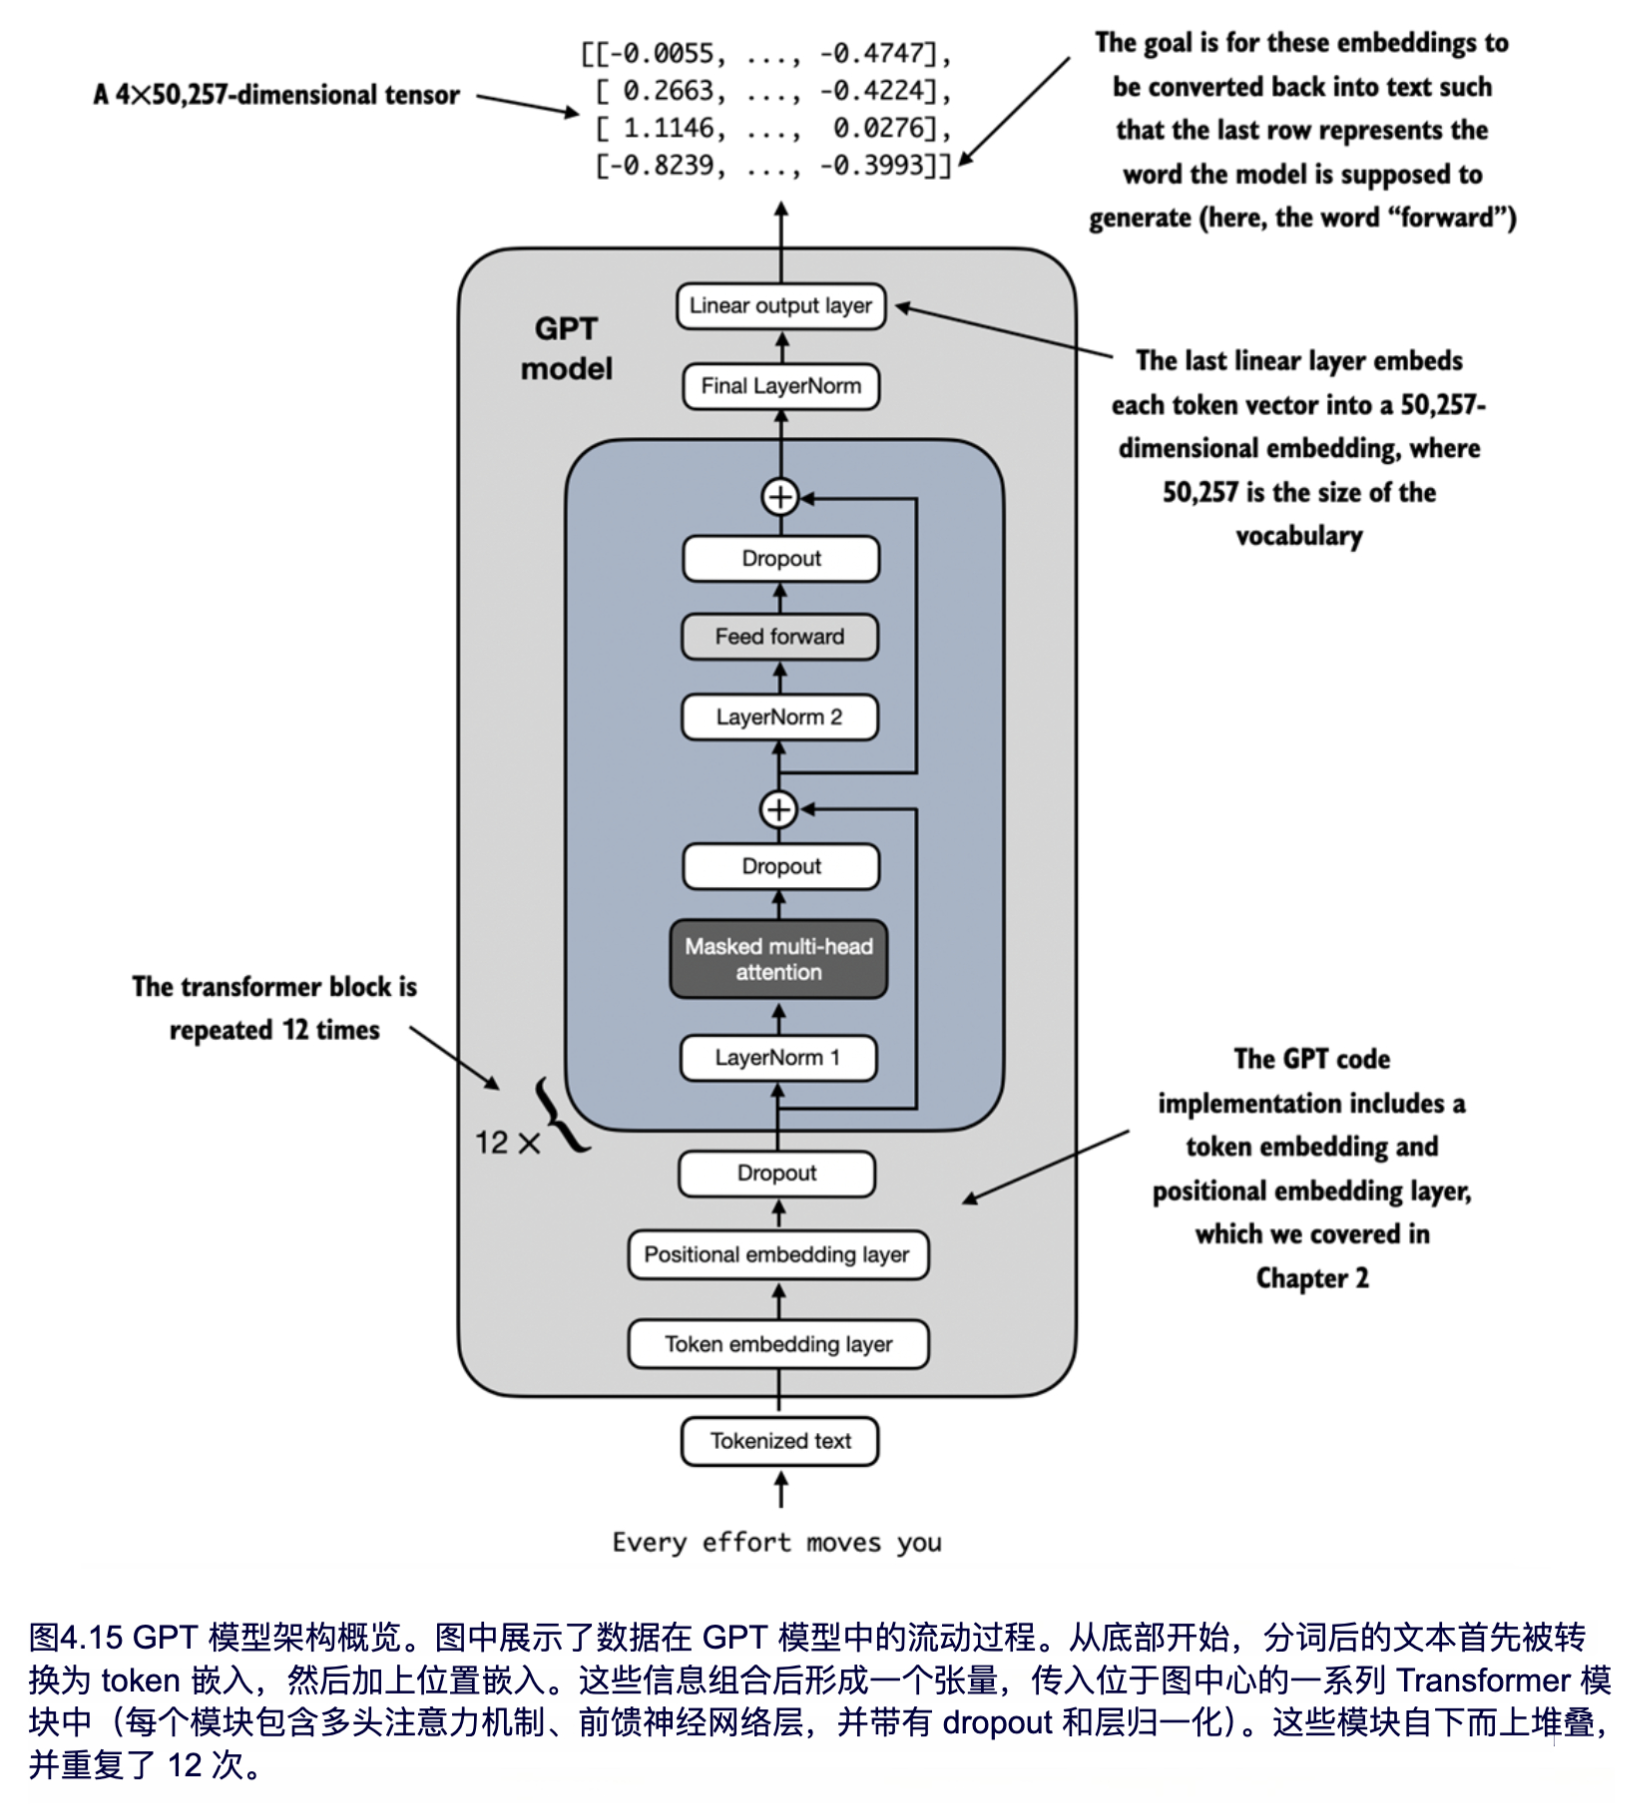

In [15]:
# 分为三大层  
# A 编码层 -> 词嵌入 位置嵌入 
# B transformer blocks
# C 输出层 归一化+输出
print(GPT_CONFIG_124M)

{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [19]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_norm = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[ TransformerBlock(cfg) for _ in range (cfg['n_layers']) ])
        self.final_norm = nn.LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'],bias=False)
    
    def forward(self, in_idx):
        batch, seq_len = in_idx.shape
        token = self.token_emb(in_idx)
        pos = self.pos_emb(torch.arange(seq_len))
        x = token + pos
        x = self.drop_norm(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits 
        

In [20]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])


In [27]:
## 参数量
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

163009536


 GPT-2 架构中使用了一种称为‘权重共享’的概念，这意味着 GPT-2 架构将 token 嵌入层的权重复用于输出层。为了更好地理解这一点，我们可以来看一下在模型中初始化的 token 嵌入层和线性输出层的形状

In [28]:
print("Token embedding layer shape:", model.token_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])
Number of trainable parameters considering weight tying: 124,412,160


In [29]:
total_size_bytes = total_params * 4                 #A
total_size_mb = total_size_bytes / (1024 * 1024)    #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

#A 计算参数总大小（假设每个参数为 float32 类型，占用 4 字节）
#B 转换为 MB


Total size of the model: 621.83 MB


## 生成文本  
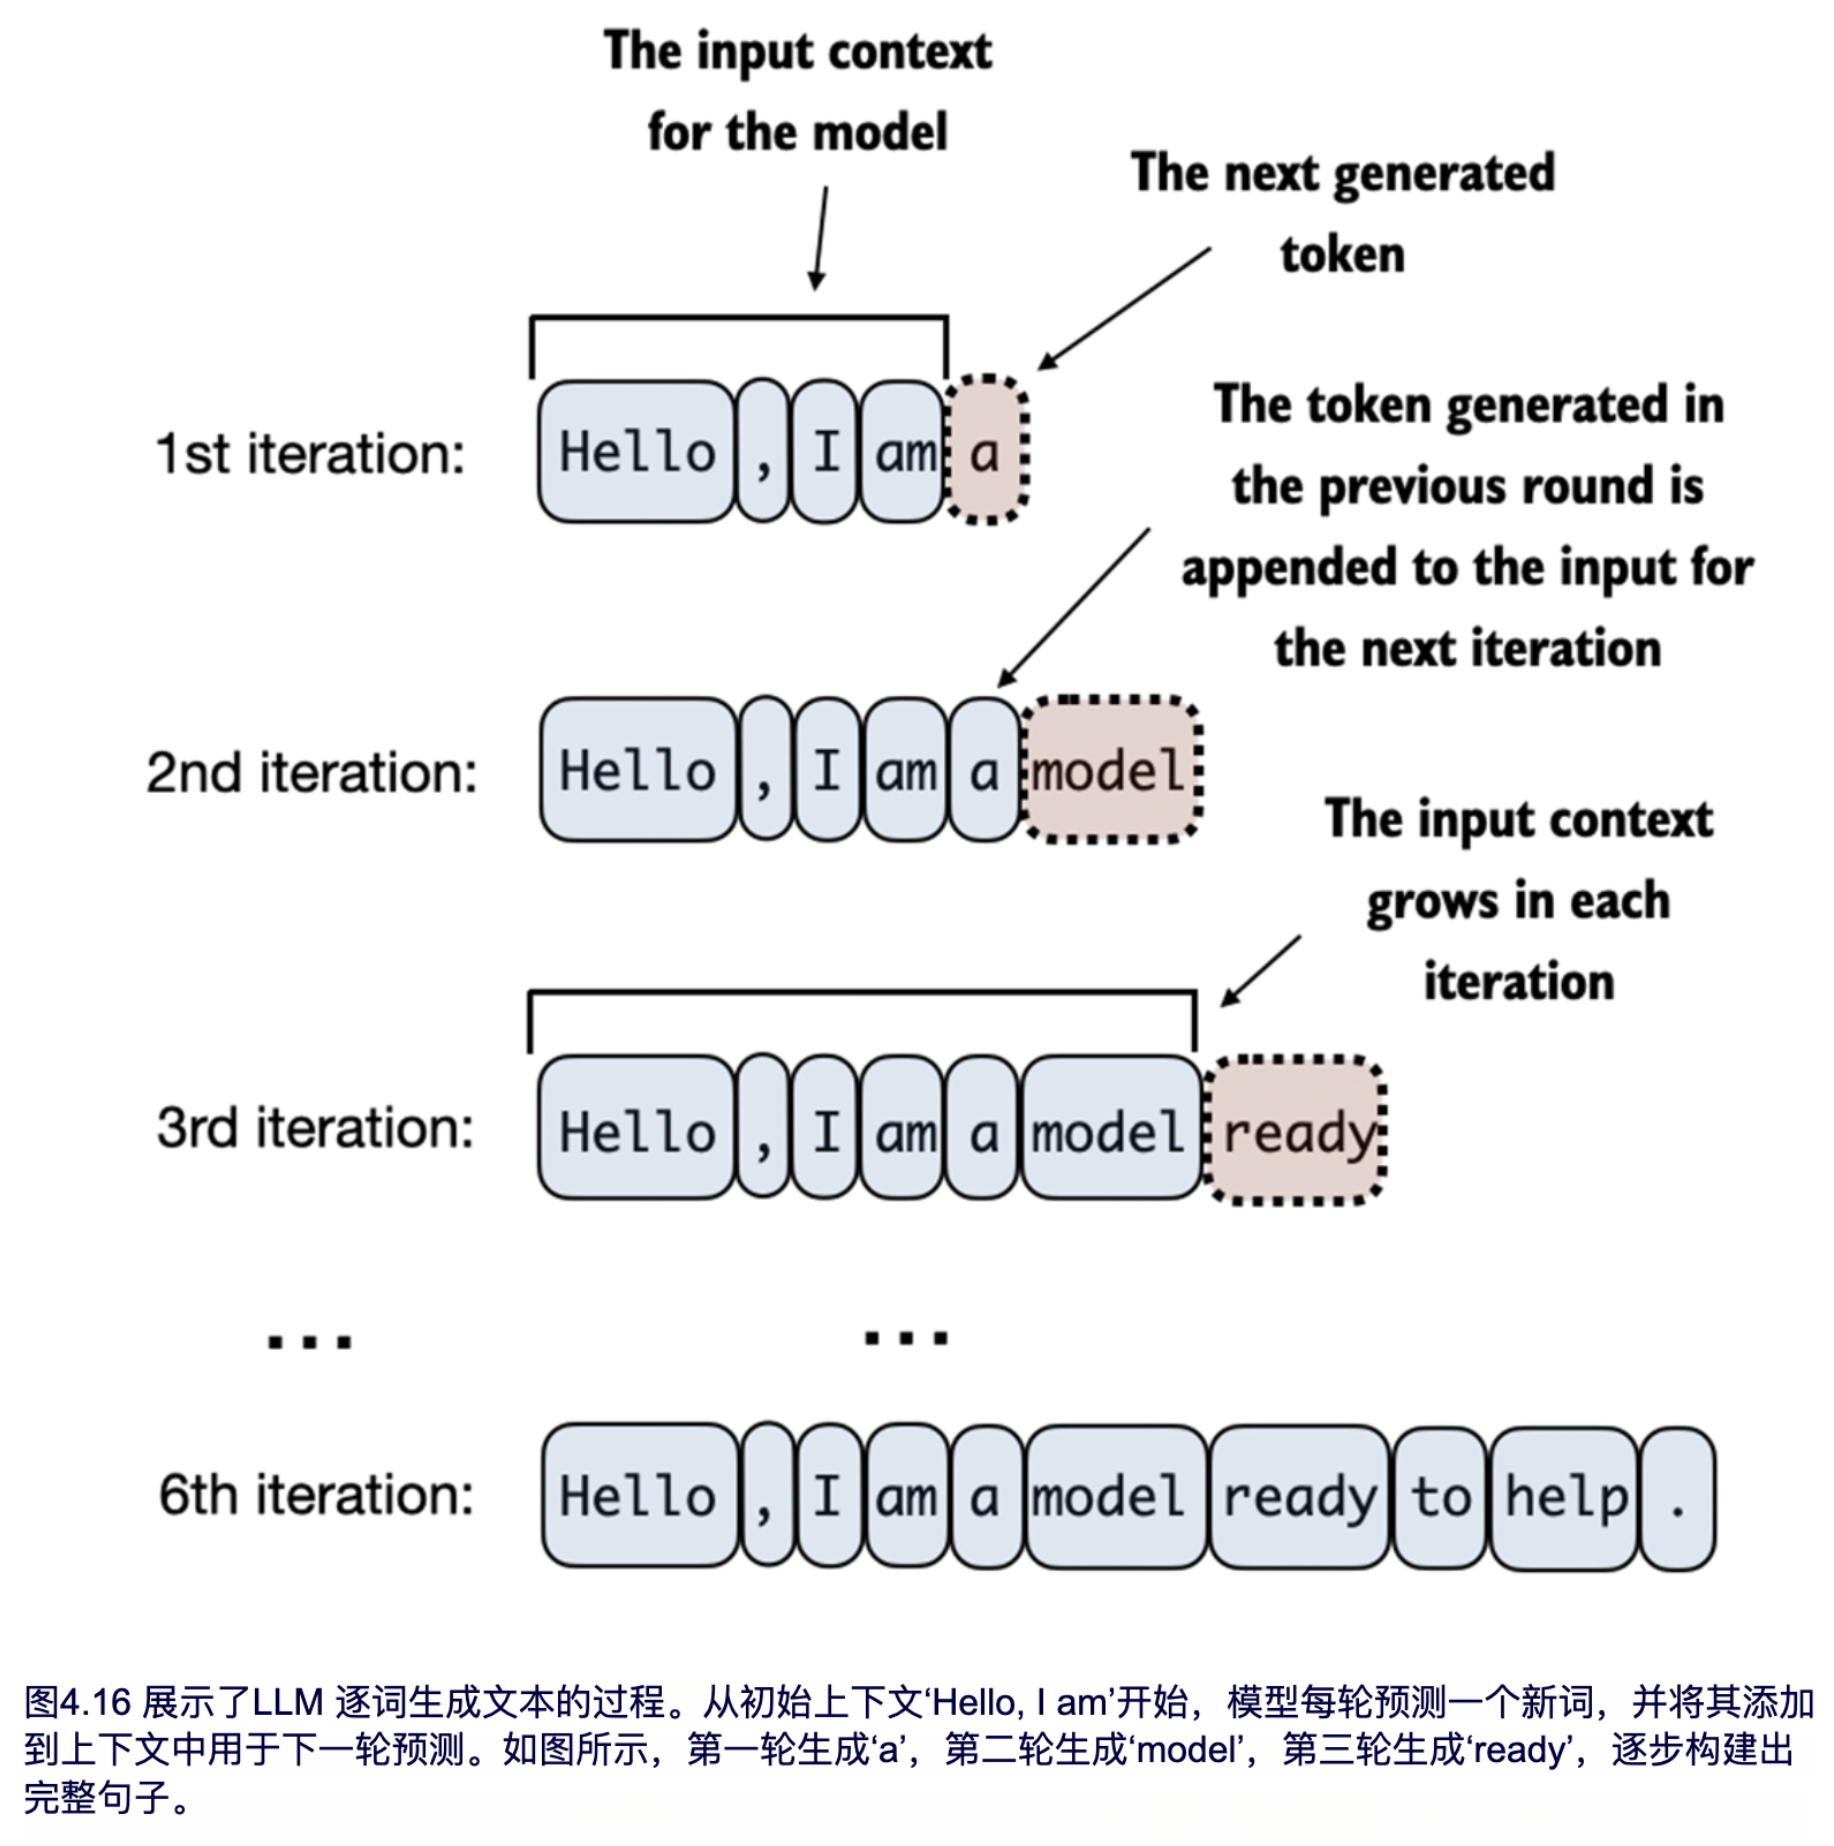

In [34]:
def generate_text_example(model, idx, max_new_tokens, context_size):
    #idx -> b,seq_len
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]#只要最后一个输出 [b, 1, 50257]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)#[b,1,1]
        idx = torch.concat((idx, idx_next), dim=-1)
    
    return idx
        
        

In [35]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print(encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

[15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [38]:
model.eval()
out = generate_text_example(model,idx=encoded_tensor, max_new_tokens=10, context_size=GPT_CONFIG_124M['context_length'])
print(out)
print(tokenizer.decode(out.squeeze(0).tolist()))

tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657]])
Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous


## 本章摘要
- 层归一化通过确保每一层的输出具有一致的均值和方差，从而稳定训练过程。
- 在大语言模型（LLM）中，快捷连接可以通过将某一层的输出直接传递给更深层来跳过一个或多个层，有助于缓解深度神经网络训练中的梯度消失问题。
- Transformer 模块是 GPT 模型的核心结构，结合了掩码多头注意力模块和使用 GELU 激活函数的全连接前馈网络。
- GPT 模型是由许多重复的 Transformer 模块组成的大语言模型，参数量高达数百万到数十亿。
- GPT 模型有不同的规模，例如 1.24 亿、3.45 亿、7.62 亿和 15.42 亿参数。这些不同规模的模型可以用同一个 GPTModel 类来实现。
- 类似 GPT 的大语言模型通过逐个预测 token，根据给定的输入上下文，将输出张量解码为可读文本，从而实现文本生成能力。
- 未经训练的 GPT 模型生成的文本往往语义不连贯，这突显了训练对于生成连贯文本的重要性，这也将是后续章节的讨论重点。